# Basic RNN-LSTM code

An RNN is good at handeling sequences, say you have a sequence of words (the weather is nice) and a train of 4 RNN "cells" where the each cell has a hidden state that we first initalize randomly. Each cell takes a word as input (the->cell1, weather->cell2 ...)  but each cell also takes the previous cell's hidden state as input too! and as the model trains on many different sentences we update those hidden states. 

The default RNN layer is to return the final hidden state for every RNN cell, or if you're batching your data the output is (batch_size, num_cells).

We can make the RNN return the hidden state of every input word instead of just the last one by using the argument `return_sequence=True`

RNN cells also have an internal state, that is used inside the cell. It is not usually useful unless you want to retain the internal state for use in resumeing training later, or if you want to train another RNN, this is usually used for encoder/decoder models where you return the state of the encoder and feed that state to the decoder. U can return the state using `return_state=True` 


## The goal of this notebook
Goal is to have the model take as input [3, 6, 4, 8] and predict the [3, 6, 0, 0] in other words
just convert the last two elements to zeros, thats it.
We will start with a list of 4 elemnts where the number of unique digits is 5, in other words our
vocabulary is 5 numbers only.



## Experiment 1: Embedding layer and fixed length sequence (length 4) and unique digits number is 5

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Embedding

from random import randint
import helpers # this is a custom helpers module I wrote

In [2]:
helpers.check_gpu_tensorflow()

is CUDA available: True
Tensorflow version  2.6.0
Keras version  2.6.0


In [3]:
num_unique_tokens = 5
sample_length = 4

training_data_size = 1000
validation_data_size = 500
testing_data_size = 250


In [4]:

X = helpers.generate_sequence(sample_length, num_unique_tokens)
y = X[:]
y[2:] = [0,0]
print(f'example feature: {X} , example label: {y}')


example feature: [1, 0, 3, 4] , example label: [1, 0, 0, 0]


In [5]:
# this generator will create our test/train/val data
def data_generator(length):
    for sample in range(length):
        X = helpers.generate_sequence(sample_length, num_unique_tokens)
        y = X[:]
        y[2:] = [0,0]
        yield (X,y)
        
data_generator(3)
    

<generator object data_generator at 0x7fc1bfa3d150>

In [6]:

train_generator = tf.data.Dataset.from_generator(data_generator, args=[training_data_size],
              output_signature=(tf.TensorSpec(shape=(2,4), dtype=tf.int32)))

for i in train_generator.repeat().batch(3).take(1):
    print(i)
    
print("without the batching \n")
    
for i in train_generator.take(1):
    print(i)

tf.Tensor(
[[[0 2 3 0]
  [0 2 0 0]]

 [[1 1 2 0]
  [1 1 0 0]]

 [[2 1 2 1]
  [2 1 0 0]]], shape=(3, 2, 4), dtype=int32)
without the batching 

tf.Tensor(
[[4 2 3 1]
 [4 2 0 0]], shape=(2, 4), dtype=int32)


In [7]:
train_ds = []
label_ds = []

test_ds = []
test_label_ds = []

#### we will not use tf.dataset, this code works but I will use a numpy array instead
# for i in train_generator.take(training_data_size):
#     train_ds.append(i[0])
#     label_ds.append(i[1])
# train_ds = tf.data.Dataset.from_tensor_slices(train_ds)
# label_ds = tf.data.Dataset.from_tensor_slices(label_ds)

# print(train_ds)
# print(label_ds)
# for i in train_ds.repeat().batch(3).take(1):
#     print(i)
    
# print("without the batching \n")
    
# for i in train_ds.take(1):
#     print(i)



for i in train_generator.take(training_data_size):
    train_ds.append(i[0])
    label_ds.append(i[1])
train_ds = np.array(train_ds)
label_ds = np.array(label_ds)
# train_ds.reshape((train_ds.shape[0], 1,train_ds.shape[1]))
print("training data shape", train_ds.shape)

for i in train_generator.take(testing_data_size):
    test_ds.append(i[0])
    test_label_ds.append(i[1])
test_ds = np.array(train_ds)
test_label_ds = np.array(label_ds)
# train_ds.reshape((train_ds.shape[0], 1,train_ds.shape[1]))


training data shape (1000, 4)


In [8]:
train_ds[0]

array([0, 0, 1, 4], dtype=int32)

## Experiment 1.1 
num_LSTM_cells = 100

output_dimintion = 10

total_epochs = 200

we only return the hidden state of the last LSTM for every cell (unit)
using a simple archetecture of

embedding -> LSTM -> Dense

'### Experiment 1.1'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          60        
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
classifier (Dense)           (None, 4)                 404       
Total params: 44,864
Trainable params: 44,864
Non-trainable params: 0
_________________________________________________________________


None

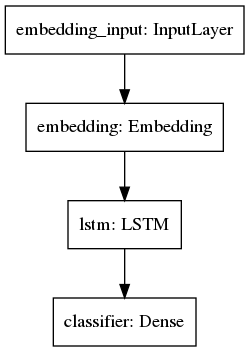

Test Accuracy: 61.500000953674316 % 



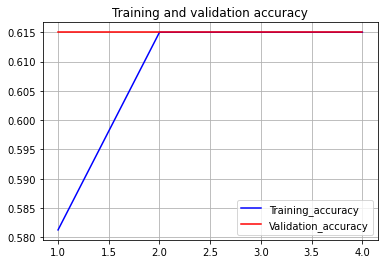

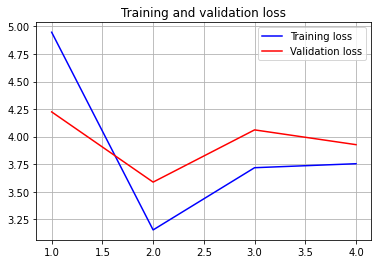

In [9]:
num_LSTM_cells = 100
output_dimintion = 10
total_epochs = 200

callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="accuracy", mode="auto", restore_best_weights=True, patience=2)]
    
model = Sequential()
model.add(Embedding(num_unique_tokens+1, output_dimintion))
model.add( LSTM(num_LSTM_cells)) 
model.add( Dense(num_unique_tokens - 1, activation='softmax', name='classifier'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
               metrics=['accuracy'])
display("### Experiment 1.1")
display(model.summary())
display(tf.keras.utils.plot_model(model))

history = model.fit(x=train_ds, y=label_ds, epochs=total_epochs,
                    verbose=0, validation_split=0.2, callbacks=callbacks )
loss, accuracy = model.evaluate(test_ds, test_label_ds, verbose=0)
print(f'Test Accuracy: {accuracy*100} % ')
# model.fit(x=train_generator, epochs=total_epochs)
helpers.plot_training_validation_accuracy_loss(history)
print()

## Experiment 1.2 
num_LSTM_cells = 100

output_dimintion = 10

total_epochs = 200

we return the hidden state of the of every LSTM cell per sample (return_sequence=True)
using a similar archetecture to Experiment 1.1 only that we need to use a TimeDistributed layer to wrap our Dense layer since we are returning a sequence and we don't use an embedding layer
of LSTM(return_sequences=True) -> TimeDistributed(Dense)

here is a good resource on TimeDistributed https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

good tutorial for lstm shape https://youtu.be/Msk-A99oo10?t=60

In [10]:
display(train_ds)
display(train_ds[0])
train_ds.shape


array([[0, 0, 1, 4],
       [4, 2, 0, 0],
       [3, 0, 4, 1],
       ...,
       [4, 2, 1, 0],
       [4, 1, 0, 1],
       [1, 4, 0, 4]], dtype=int32)

array([0, 0, 1, 4], dtype=int32)

(1000, 4)

In [11]:
# The shape of one sequence is 1 row and 4 columns ie (1,4) 
# also known as 1 timestep and 4 features
# so we must reshape our data to be of shape (num_samples, 1 ,4) 
# currently our data shape is (num_samples, 4) so we need to add one dimention

train_reshaped_ds = train_ds.reshape(len(train_ds),1,4)
print(train_reshaped_ds.shape)
train_reshaped_ds

(1000, 1, 4)


array([[[0, 0, 1, 4]],

       [[4, 2, 0, 0]],

       [[3, 0, 4, 1]],

       ...,

       [[4, 2, 1, 0]],

       [[4, 1, 0, 1]],

       [[1, 4, 0, 4]]], dtype=int32)

In [12]:
label_reshaped_ds = label_ds.reshape(len(label_ds),1,4)
test_reshaped_ds = test_ds.reshape(len(test_ds),1,4)
test_reshaped_label_ds = test_label_ds.reshape(len(test_label_ds),1,4)

In [13]:
print(train_ds.shape)

callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="accuracy", mode="auto", restore_best_weights=True, patience=2)]
    
model = Sequential()
model.add( LSTM(num_LSTM_cells, input_shape=(1,4), return_sequences=True))
dense = TimeDistributed(Dense(num_unique_tokens - 1, activation='softmax', name='classifier'))
model.add(dense)

model.compile(loss='categorical_crossentropy', optimizer='adam',
               metrics=['accuracy'])
display("### Experiment 1.2")
display(model.summary())

history = model.fit(x=train_reshaped_ds, y=label_reshaped_ds, epochs=total_epochs,
                    verbose=0, validation_split=0.2, callbacks=callbacks )

print()


(1000, 4)


'### Experiment 1.2'

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            42000     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              404       
Total params: 42,404
Trainable params: 42,404
Non-trainable params: 0
_________________________________________________________________


None

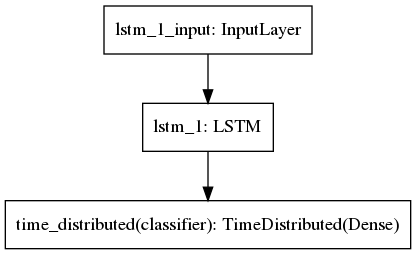

Test Accuracy: 89.70000147819519 % 


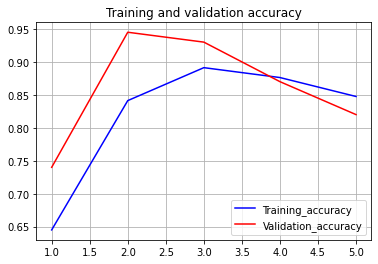

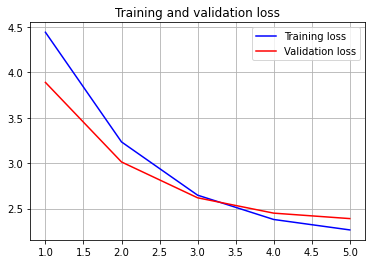

In [14]:
display(tf.keras.utils.plot_model(model))
loss, accuracy = model.evaluate(test_reshaped_ds, test_reshaped_label_ds, verbose=0)
print(f'Test Accuracy: {accuracy*100} % ')
helpers.plot_training_validation_accuracy_loss(history)

## Experiment 1.3 

num_LSTM_cells = 100
output_dimintion = 10
total_epochs = 200

Same as 1.2 but we use an embedding layer this time
embedding --> LSTM --> TimeDistributed(Dense))

In [62]:
print(train_ds.shape)

callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="accuracy", mode="auto", restore_best_weights=True, patience=3)]
    
model = Sequential()
model.add(Embedding(num_unique_tokens+1, output_dimintion, input_length=4))
model.add(LSTM(num_LSTM_cells, input_shape=(4, output_dimintion) ,return_sequences=True))
dense = TimeDistributed(Dense(num_unique_tokens - 1, activation='softmax', name='classifier'))
model.add(dense)

# model.add(LSTM(num_LSTM_cells) )
# model.add(Dense(num_unique_tokens - 1, activation='softmax', name='classifier'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
               metrics=['accuracy'])
display("### Experiment 1.2")
display(model.summary())

history = model.fit(x=train_ds, y=label_ds, epochs=total_epochs*5,
                    verbose=0, validation_split=0.2, callbacks=callbacks )

p = model.predict(train_ds)
p.shape

(1000, 4)


'### Experiment 1.2'

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 4, 10)             60        
_________________________________________________________________
lstm_49 (LSTM)               (None, 4, 100)            44400     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 4, 4)              404       
Total params: 44,864
Trainable params: 44,864
Non-trainable params: 0
_________________________________________________________________


None

ValueError: in user code:

    /home/mo/.local/lib/python3.6/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/mo/.local/lib/python3.6/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/mo/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mo/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mo/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mo/.local/lib/python3.6/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /home/mo/.local/lib/python3.6/site-packages/keras/engine/training.py:789 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/mo/.local/lib/python3.6/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/mo/.local/lib/python3.6/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /home/mo/.local/lib/python3.6/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/mo/.local/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/mo/.local/lib/python3.6/site-packages/keras/losses.py:1666 categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    /home/mo/.local/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/mo/.local/lib/python3.6/site-packages/keras/backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/mo/.local/lib/python3.6/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 4) and (32, 4, 4) are incompatible


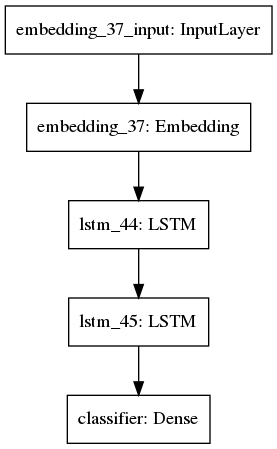

Test Accuracy: 61.500000953674316 % 


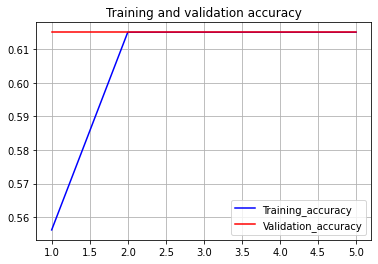

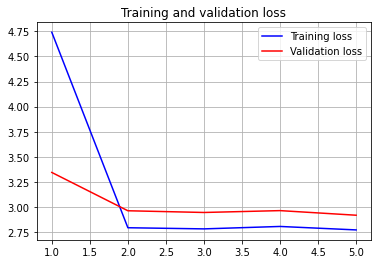

In [54]:
display(tf.keras.utils.plot_model(model))
loss, accuracy = model.evaluate(test_ds, test_label_ds, verbose=0)
print(f'Test Accuracy: {accuracy*100} % ')
helpers.plot_training_validation_accuracy_loss(history)